In [1]:
## all the necessary imports for the project

import json
import pickle
from gcmap import GCMapper, Gradient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import PowerNorm, LogNorm, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
import matplotlib.patches as mpatches
from fuzzywuzzy import process
from tqdm import tqdm
from functools import cache
import networkx as nx
import netwulf
import matplotlib.pyplot as plt

C:\Users\Andba\AppData\Local\Temp\ipykernel_5860\392187014.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Motivation
We have chosen to work with a dataset of airports and flight connections between airports. Also, we will be looking at written reviews aswell as numerical, binary reviews ('recommended' or 'not recommended'). We want to answer the following research question:

***Where are the best airports located in the world? Are these airports connected to other airports of high quality? And, when adjusted for BNP per capita, where are the best airports compared to regional development?***

There are multiple ways of determining what a good airport is. We'll be looking at "average recommendation" (what percentage of users recommend the airport), "sentiment score" (how does people decribe the airports in textual reviews), and how well the airport is connected to other airports. 

To do this, we have chosen to work with the following datasets:
* [airports.dat](https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat): The ID, city, country, and much more (13 attributes) of 7698 airports all over the globe. **Source**: January 2017, DAFIF (Digital Aeronautical Flight Information File) and OurAirports
* [routes.dat](https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat): The source and destination, and more (9 attributes) of 67663 flights connecting between airports. **Source:** June 2014, Airline Route Mapper.
* [Airport reviews](https://github.com/quankiquanki/skytrax-reviews-dataset): 17721 text reviews of airports all over the world. Most text reviews also have a numerical rating. **Source**: github-user quankiquanki, obtained from Skytrax between 2007 and 2015.

We also collected information about BNP per capita and continents of the different countries/airports for two reasons: to standardize the airport ratings with regards to regional development (i.e. is there some airports that performs much better than expected based on BNP?) and to classify the airports into regions/continents for a high level grouping of airports.

* [BNP per capita](https://ourworldindata.org/grapher/gdp-per-capita-worldbank?time=2015): The BNP per capita of most countries in the world. Multiple years are available, we choose 2015 to overlap with the reviews. **Source**: World Bank (2023).
* [Continents](https://ourworldindata.org/world-region-map-definitions): The contient/region of every country. There are multiple ways of classifying regions of countries, we went with the more "traditional" way. **Source**: Our World In Data. 

### Our goal
Our goal is to give people an understanding of what level of quality one can expect from airports in differents parts of the world, both in terms of user satisfaction but also in terms of connectivity to other airports. 

# Basic stats
### Cleaning and preprocessing
First, we'll look at the "airports" dataset. This dataset contains the following attributes:
* id (name of airport)
* city
* country
* IATA (unique 3-letter code)
* ICAO (unique 4-letter code)
* latitude
* longitude
* altitude
* timezone 
* DST (daylight savings time)
* Tz database time zone (timezone in "tz" format)
* type (always airport)
* source

We are only interested in a subset of these, in particular *id, city, country, IATA, latitude* and *longitude*.
Therefore, we start of by removing NaN values where it matters (i.e. in the columns mentioned above).

In [2]:
cols = ["id", "city", "country", "IATA", "ICAO", "latitude", "longitude", "altitude", "timezone", "DST", "Tz database time zone", "type", "source"]
cols_to_remove = ["ICAO", "altitude", "timezone", "DST", "Tz database time zone", "type", "source"]
airports = pd.read_csv('data/airports.csv', index_col=0, names=cols, header=None)
airports = airports.drop(cols_to_remove, axis=1)
print("Length of airports before sorting: ", len(airports))

subset = ["IATA", "latitude", "longitude", "country", "city"]
airports = airports.dropna(subset=subset)
for col in subset:
    airports = airports[airports[col] != "\\N"]
    
print("Length of airports after sorting: ", len(airports))

Length of airports before sorting:  7698
Length of airports after sorting:  6033


Next, we make a dictionary mapping from country to continent, such that we can add continent to the above dataframe.

In [3]:
continents = pd.read_csv('data/continents.csv')
## make a dictionary of country to continent
country_to_continent = {}
for index, row in continents.iterrows():
    country = row['Entity']
    country_to_continent[row['Entity']] = row['Continent']
    
## show the first 5 entries of the dictionary
print("Example of country to continent dictionary:")
dict(list(country_to_continent.items())[0:5])

Example of country to continent dictionary:


{'Abkhazia': 'Asia',
 'Afghanistan': 'Asia',
 'Akrotiri and Dhekelia': 'Asia',
 'Aland Islands': 'Europe',
 'Albania': 'Europe'}

Similarily, we make a dictionary that maps from country to BNP, such that this can be added to the dataframe aswell. 
We only consider BNP from 2015, since this also around the time that the reviews are  gathered. 

In [4]:
BNP_per_capita = pd.read_csv('data/gdp-per-capita-worldbank.csv')
BNP_per_capita_2015 = BNP_per_capita[BNP_per_capita["Year"] == 2015]
## make a dictionary of country to BNP per capita
country_to_BNP_per_capita = {}
for index, row in BNP_per_capita_2015.iterrows():
    country = row['Entity']
    country_to_BNP_per_capita[country] = row['GDP per capita, PPP (constant 2017 international $)']
## see first 5 entries of the dictionary
print("Example of country to BNP per capita dictionary:")
dict(list(country_to_BNP_per_capita.items())[0:5])

Example of country to BNP per capita dictionary:


{'Afghanistan': 2108.714,
 'Albania': 11880.598,
 'Algeria': 11751.634,
 'Angola': 7967.104,
 'Antigua and Barbuda': 19345.018}

The data of continents/BNP comes from Our World In Data (OWID), and it doesn't match with the country names from the airport dataset. Therefore, we manually have to fix these names. 

In [5]:
countries_from_airports = airports['country'].unique()
countries_from_continents = continents['Entity'].unique()
countries_from_BNP = BNP_per_capita_2015['Entity'].unique()
## make a set of unique countries from continents and BNP
unique_countries = set(countries_from_continents).union(set(countries_from_BNP))
unique_countries = list(unique_countries)

## find the countries that are in airports but not in continents
print("These names should be fixed:")
print("-" * 20)
for country in countries_from_airports:
    if country not in unique_countries:
        print(country)
    
    
## this function is written AFTER examining the mismash of country names in the airports dataset
## and the continents dataset
## based on the print statement above ^
## we then manually looked at the mismatches and fixed them
def fix_country_name(name : str) -> str:
    """
    Function for matching up the country names in the airports dataset with the country names in the continents dataset.
    """
    
    if name[:5] == "Congo":
        return "Congo"
    
    if name == "Czech Republic":
        return "Czechia"
    
    if name == "Macedonia":
        return "North Macedonia"
    
    if name == "Swaziland":
        return "Eswatini"
    
    if name == "Micronesia":
        return "Micronesia (country)"
    
    if name == "Burma":
        return "Myanmar"
    
    if name in ["Midway Islands", "US Virgin Islands", "Virgin Islands", "Johnston Atoll", "Wake Island"]:
        return "United States"
    
    if name == "Macau":
        return "China"
    
    if name == "Cocos (Keeling) Islands":
        return "Australia"
    
    if name == "Russian Federation":
        return "Russia"
    
    return name

These names should be fixed:
--------------------
Congo (Brazzaville)
Congo (Kinshasa)
Swaziland
Czech Republic
Macedonia
Midway Islands
Micronesia
Virgin Islands
Macau
Burma
Johnston Atoll
Cocos (Keeling) Islands
Wake Island


We use the fixed country names to go from one dataset to the other. This way, we can confidently attribute the correct continent and BNP to each airport. 

In [6]:
## make a new column in the airports dataset with the continent
airports['continent'] = airports['country'].apply(fix_country_name).map(country_to_continent)
## same for the BNP per capita
airports['BNP per capita'] = airports['country'].apply(fix_country_name).map(country_to_BNP_per_capita)
## if the BNP is a nan, fill it with the mean
airports['BNP per capita'] = airports['BNP per capita'].fillna(airports['BNP per capita'].mean())

### Processing reviews
Now, we are going to look at the dataset of reviews. The reviews contains both text and numerical reviews. However, once again there are discrepancies between the names of the different datasets. This time, the names of each airport differs slightly. Therefore, we want to map each airport name from the "reviews" to the corresponding airport in the "airports" dataset. 
To do this, we will use the Levenshtein distance, which has been implemented in the python package `fuzzywuzzy`. 

**Optimization:** Unfortunately, the Levenshtein distance takes some time to run, and we have quite a lot of reviews. But since the same airports have multiple reviews, we don't need to calculate the corresponding name for each review but only for each airport. Therefore, we use the `functools.cache` wrapper which can remember function evaluations. 
This way, we have optimized our code from ~ 3 hours to ~ 5 minutes. 

The Levenshtein distance is defined as:
$$
lev(a[1..m], b[1..n]) = 
\begin{cases} 
m & \text{if } n = 0 \\
n & \text{if } m = 0 \\
lev(a[1..m-1], b[1..n-1]) & \text{if } a[m] = b[n] \\
1 + \min\begin{cases}
lev(a[1..m-1], b[1..n]) \\
lev(a[1..m], b[1..n-1]) \\
lev(a[1..m-1], b[1..n-1])
\end{cases} & \text{if } a[m] \neq b[n]
\end{cases}
$$
and it measures the number of deletions, substitutions, and insertions neccesary to go from string $a$ to string $b$. 

In [7]:
tqdm.pandas()

def format_name(name):
    name = name.replace("-", " ")
    ## make first letter in each word uppercase
    name = " ".join([word.capitalize() for word in name.split()])
    return name

@cache
def match_name(name, candidates):
    name = format_name(name)
    if name in candidates:
        return name
    
    ## get the best match
    match, score = process.extractOne(name, candidates)
    if score > 90:
        return match
    
    return None

In [8]:
airportreviews = pd.read_csv("data/airportreviews.csv")
cols_to_keep = ["airport_name", "recommended", "content"]
airportreviews = airportreviews[cols_to_keep]
airportreviews = airportreviews.dropna(subset=cols_to_keep)

candidates = airports['id'].unique()
candidates = tuple(candidates)
airportreviews["matched_name"] = airportreviews["airport_name"].progress_apply(lambda x: match_name(x, candidates))
airportreviews = airportreviews.dropna(subset=["matched_name"])

100%|██████████| 17721/17721 [05:59<00:00, 49.25it/s] 


Next up, we process the text reviews and numerical ratings of each airport. 
Text reviews are processed as a list of strings. 
Numerical ratings comes as 1's or 0's, i.e. "recommend" and "don't recommend". We have found the average of these numerical ratings, which amount to the fraction of positive reviews.
These are added to the "airports" dataset as a new column. 

**Optimization:** All this can be done extremely effective using the `groupby`, `apply` and `merge` functions in pandas. 

In [9]:
## for each airport in airports dataframe, insert the average recommendation score from airportsreviews
airportreviews["recommended"] = airportreviews["recommended"].astype(int)
average_recommendation = airportreviews.groupby("matched_name")["recommended"].mean().reset_index()
reviews_as_list = airportreviews.groupby("matched_name")["content"].apply(list).reset_index()
number_of_reviews = airportreviews.groupby("matched_name")["content"].count().reset_index()

average_recommendation.columns = ["id", "average_recommendation"]
reviews_as_list.columns = ["id", "reviews"]
number_of_reviews.columns = ["id", "number_of_reviews"]

airports = pd.merge(airports, number_of_reviews, how="left")
airports = pd.merge(airports, reviews_as_list, how="left")
airports = pd.merge(airports, average_recommendation, how="left")

## make a new column in airports which is recommended / BNP per capita 
## only if both are not nan
airports["recommended_BNP_ratio"] = np.nan
mask = (~airports["average_recommendation"].isna()) & (~airports["BNP per capita"].isna())
normalized_BNP = airports.loc[mask, "BNP per capita"] / airports.loc[mask, "BNP per capita"].max()
airports.loc[mask, "recommended_BNP_ratio"] = airports.loc[mask, "average_recommendation"] / normalized_BNP

In [10]:
## save to csv
## change to True if you want to save the airports dataframe to a csv file
## no need to run this cell if you don't want to save the dataframe
airports.to_csv("data/airports_cleaned.csv", index=False)

Unfortunately, a lot of aiport dont have any reviews. Our dataset contains a total of 6033 airports, but only 302 have reviews. 

In [11]:
print("Number of unique airport names in dataset:", len(airports))
airports_with_reviews = airports[airports["average_recommendation"].notnull()]
print("Number of unique airport names in reviews (i.e. number of airports with reviews):", len(airports_with_reviews))

Number of unique airport names in dataset: 6033
Number of unique airport names in reviews (i.e. number of airports with reviews): 302


### The final airport dataset
We now have the final dataset for the airports.

In [75]:
print("Size of dataframe in megabytes:", airports.memory_usage(deep=True).sum() / (1024 ** 2), "\n")
print("Rows and columns in dataframe:", airports.shape, "\n")
print("The variables in the dataframe are:")
print(airports.columns.tolist(), "\n")
print("The first 5 rows of the dataframe are:")
print(airports.head())

Size of dataframe in megabytes: 9.33131217956543 

Rows and columns in dataframe: (6033, 12) 

The variables in the dataframe are:
['id', 'city', 'country', 'IATA', 'latitude', 'longitude', 'continent', 'BNP per capita', 'number_of_reviews', 'reviews', 'average_recommendation', 'recommended_BNP_ratio'] 

The first 5 rows of the dataframe are:
                                            id          city  \
0                               Goroka Airport        Goroka   
1                               Madang Airport        Madang   
2                 Mount Hagen Kagamuga Airport   Mount Hagen   
3                               Nadzab Airport        Nadzab   
4  Port Moresby Jacksons International Airport  Port Moresby   

            country IATA  latitude   longitude continent  BNP per capita  \
0  Papua New Guinea  GKA -6.081690  145.391998   Oceania       3813.1143   
1  Papua New Guinea  MAG -5.207080  145.789001   Oceania       3813.1143   
2  Papua New Guinea  HGU -5.826790  144.29

### Making the graph
To make the graph, we'll use Networkx. We'll format the graph as a dictionary to start of, which can then be passed to Networkx to create an actual graph. First, we'll make a dictionary for all nodes with their attributes (cityname, country, and so on). Each node will have a name according to their IATA (International Air Transport Association) code, which is a unique 3 digit identifier for each airport. 

In [50]:
## make a dictionary of IATA codes
## IATA code is a three-letter code designating many airports around the world
## for each airport, safe relevant information in a dictionary
IATA = {}
n = 0
for index, row in tqdm(airports.iterrows(), total=len(airports)):
    
    IATA[row['IATA']] = {
        'city': row['city'],                                                ## city
        'country': row['country'],                                          ## country
        'latitude': row['latitude'],                                        ## latitude
        'longitude': row['longitude'],                                      ## longitude
        'name': row['id'],                                                  ## name        
        'continent': row['continent'],                                      ## continent
        'group': row['continent'],                                          ## group      
        'BNP_per_capita': row['BNP per capita'],                            ## BNP per capita
        'average_recommendation': row['average_recommendation'],            ## average recommendation
        'average_recommendation_per_BNP': row['recommended_BNP_ratio'],     ## average recommendation per BNP
        'number_of_reviews': row['number_of_reviews'],                      ## number of reviews
    }
    
## save the dictionary to a file
with open('data/IATA.json', 'w') as f:
    json.dump(IATA, f)

  0%|          | 0/6033 [00:00<?, ?it/s]

100%|██████████| 6033/6033 [00:00<00:00, 6610.64it/s]


Now, lets look at the "flight" dataset, i.e. the dataset over flight connections. Once again, we'll filter this dataset by excluding NaN values and by only considering direct flight. 

In [51]:
cols = ["airline", "airline id", "source airport", "source airport id", "destination airport", "destination airport id", "codeshare", "stops", "equipment"]
flights = pd.read_csv('data/flights.csv', names=cols, header=None)
print("Number of connections before filtering:", len(flights))
flights = flights.dropna(subset=['source airport', 'destination airport'])
flights = flights[flights['stops'] == 0]  ## only direct flights
print("Number of connections after filtering:", len(flights))

Number of connections before filtering: 67663
Number of connections after filtering: 67652


### Making the graph
Now, we can make the graph. First, we'll add all nodes to the graph, and we will then add connections. 
The graph have been visualized using `netwulf`. 
NOTICE: when using `netwulf` we DO NOT consider the spatial position of each node. This will come later. 
<br>
We also remove nodes with no connections. Reason: we interpret nodes with no edges (i.e. airports with no flights) as missing data, since an airport is of no use if it is not connected to other airports. 

In [76]:
## makes a graph of the flights
## the graph is a directed graph since the flights are one way
## nodes are cities, and edges are flights between cities
## the weight of the edge is the number of flights between the cities

G = nx.DiGraph()

print("Making nodes with attributes..")
for node, data in tqdm(IATA.items()):
    G.add_node(node, **data)

print("Making edges..")
for index, row in tqdm(flights.iterrows(), total=flights.shape[0]):
    source = row['source airport']
    dest = row['destination airport']
    if source in IATA.keys() and dest in IATA.keys():
        if G.has_edge(source, dest):
            G[source][dest]['weight'] += 1
        else:
            G.add_edge(source, dest, weight=1)
            
## remove nodes with no edges
print("Number of nodes before removing isolates: ", G.number_of_nodes())
G.remove_nodes_from(list(nx.isolates(G)))
 
with open('data/graphnetwork.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

Making nodes with attributes..


100%|██████████| 6033/6033 [00:00<00:00, 92639.63it/s]


Making edges..


100%|██████████| 67652/67652 [00:06<00:00, 9740.44it/s] 

Number of nodes before removing isolates:  6033
Number of nodes:  3256
Number of edges:  37038


In [53]:
if False:
    ## make a new graph ONLY with 'group' attribute
    ## because netwulf crashes if some of the attributes are nan
    G_group = nx.DiGraph()
    for node, data in G.nodes(data=True):
        G_group.add_node(node, group=data['group'])
        
    for source, dest, data in G.edges(data=True):
        G_group.add_edge(source, dest, weight=data['weight'])
    
    config = {'zoom': 0.6,
    'node_charge': -45,
    'node_gravity': 0.1,
    'link_distance': 15,
    'link_distance_variation': 0,
    'node_collision': True,
    'wiggle_nodes': False,
    'freeze_nodes': False,
    'node_fill_color': '#79aaa0',
    'node_stroke_color': '#555555',
    'node_label_color': '#000000',
    'display_node_labels': False,
    'scale_node_size_by_strength': True,
    'node_size': 31.6736077232895,
    'node_stroke_width': 1,
    'node_size_variation': 0.30996494265163715,
    'link_color': '#7c7c7c',
    'link_width': 2,
    'link_alpha': 0.5,
    'link_width_variation': 1.079538259141508,
    'display_singleton_nodes': True,
    'min_link_weight_percentile': 0,
    'max_link_weight_percentile': 1}
    network, config =netwulf.visualize(G_group, config=config)
    fig, ax = netwulf.draw_netwulf(network)
    plt.savefig("images/network.png")

Temporary graph plot. We will focus later on visualizing the graph on a map with the correct edges (as arc circles, i.e. the seemingly rounded paths that planes fly in). For now, we'll use this plot as a sanity check, confirming that our graph is well-constructed.
![netwulf graph](images/network.png)

### Visualizing the graph as a map
In this part, we will make a few visualizations of our network. 
We have a big focus on the fact that our graph-nodes have (x,y) coordinates which can be visualized on a map. 

In [54]:
## load the IATA data again
# (in case you want to run the notebook from here without running the previous cells)
with open('data/IATA.json') as f:
    IATA = json.load(f)
    
## load the graph network
with open('data/graphnetwork.gpickle', 'rb') as f:
    G = pickle.load(f)

We use a relevant python package, `gcmap`, to visualize the great circles that the planes fly in. 

In [55]:
## make G undirected
G_undirect = G.to_undirected(reciprocal=True)
source_lon, source_lat, destination_lon, destination_lat, nb_flights = [], [], [], [], []
edges = G_undirect.edges(data=True)
for u, v, data in edges:
    if u != v:
        source_lon.append(IATA[u]['longitude'])
        source_lat.append(IATA[u]['latitude'])
        destination_lon.append(IATA[v]['longitude'])
        destination_lat.append(IATA[v]['latitude'])
        nb_flights.append(data['weight'])
        
grad = Gradient(((0, 0, 0, 0), (0.5, 204, 0, 153), (1, 255, 204, 230)))
gcm = GCMapper(cols=grad, height=2000, width=4000)
gcm.set_data(source_lon, source_lat, destination_lon, destination_lat, nb_flights)
img = gcm.draw()
img.save('images/flightmap.png')

![flightmap](images/flightmap.png)

To make things more manageable, we plot the nodes in another plot with a unique color for each continent.
The size of each node is proportional to the degree of the node. 

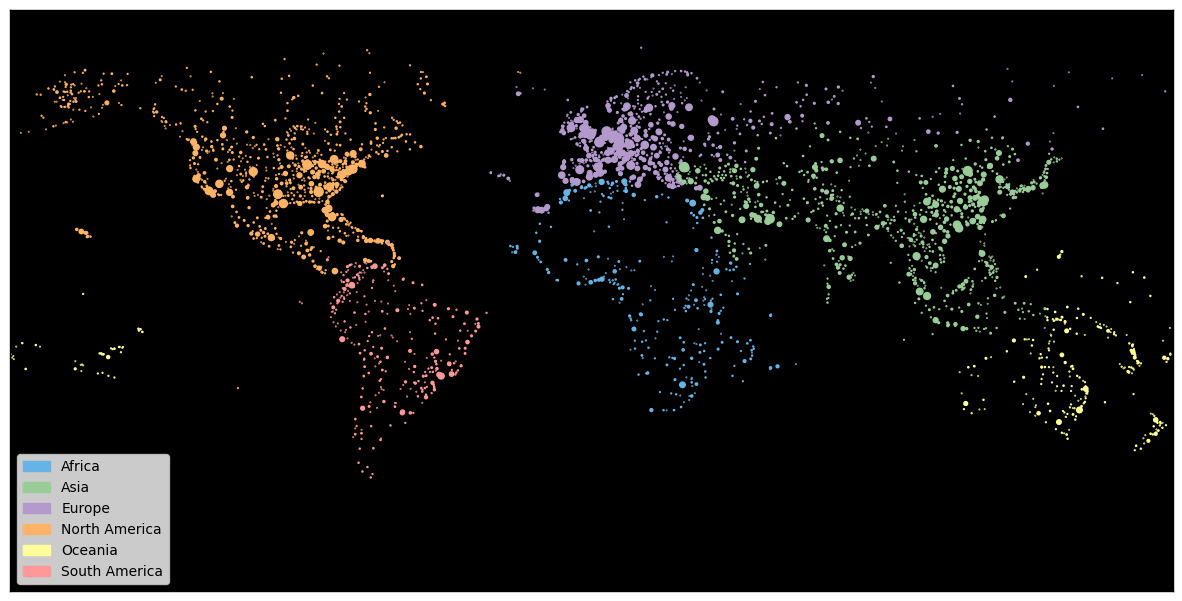

In [56]:
## create a basemap
fig, ax = plt.subplots(figsize=(15, 10))
resolution = "c"
m = Basemap(lon_0=0, resolution=resolution)
m.drawmapboundary(fill_color='black')
# m.drawcoastlines(color="lightgrey", linewidth=0.3)

continent_to_color = {
    'Africa': (0.4, 0.7, 0.9), 
    'Asia': (0.6, 0.8, 0.6), 
    'Europe': (0.7, 0.6, 0.8), 
    'North America': (1.0, 0.7, 0.4), 
    'Oceania': (1.0, 1.0, 0.6), 
    'South America': (1.0, 0.6, 0.6)
    }

## plot the nodes
lons = [IATA[node]['longitude'] for node in G_undirect.nodes()]
lats = [IATA[node]['latitude'] for node in G_undirect.nodes()]
sizes = [0.2 * G_undirect.degree(node) for node in G_undirect.nodes()]
colors = [continent_to_color[IATA[node]['continent']] for node in G_undirect.nodes()]
x, y = m(lons, lats)
m.scatter(x, y, c=colors, s=sizes)
plt.legend(handles=[mpatches.Patch(color=continent_to_color[continent], label=continent) for continent in continent_to_color])
plt.savefig('images/flightmap_nodes.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

# Tools, theory and analysis

### Working with text

# Visualizing the numerical ratings
We really wanted to visualize how the airports around the globe is rated. We wanted to paint the whole worldmap depending on the quality of aiports in the different regions. We considered multiple ways of doing it, and we ended up agreeing on doing regression to interpolate this score based on nearby airports using a Gaussian Process. 
The good thing about a Gaussian Process is that it also reports an error in each point, and we can therefore color in areas where the regression model in uncertain about the target value. This would be places where there is no airport close by with any reviews. 

So, we made two functions, one for fitting a Gaussian Process to the (x,y) coordinates, and one for plotting the results.

In [57]:
def fit_gp(X, y, alfa_uncertainty = 0.1, resolution=1000, length_scale=15):
    kernel = RBF(length_scale=length_scale, length_scale_bounds="fixed")
    model = GaussianProcessRegressor(kernel=kernel, alpha=alfa_uncertainty, normalize_y=True)
    model.fit(X, y)

    lats, lons = X[:, 0], X[:, 1]
    min_lats, max_lats = -90, 90
    min_lons, max_lons = -180, 180

    lats = np.linspace(min_lats, max_lats, resolution)
    lons = np.linspace(min_lons, max_lons, resolution)
    lats, lons = np.meshgrid(lats, lons)
    Xmesh = np.vstack([lats.ravel(), lons.ravel()]).T
    ymesh, uncertainty = model.predict(Xmesh, return_std=True)
    uncertainty = uncertainty.reshape((resolution, resolution))
    ymesh = ymesh.reshape((resolution, resolution))
    
    return lons, lats, ymesh, uncertainty

def visualize_gp(lons, lats, ymesh, uncertainty, max_uncertainty, title="", label=""):
    ## make a grey cmap, that always returns grey
    min_ymesh, max_ymesh = np.min(ymesh), np.max(ymesh)
    
    cmap_grey = LinearSegmentedColormap.from_list(
        "grey", 
        [(min_ymesh, "grey"), (max_ymesh, "grey")]
    )
    
    c = ["red","orange","yellow","palegreen","green","darkgreen"]
    cmap=LinearSegmentedColormap.from_list('rg',c, N=256)
    m = Basemap(lon_0=0)
    
    def is_water(lat, lon):
        return not m.is_land(lon, lat)

    resolution, _ = ymesh.shape
    try: 
        ywater = np.load(f"data/ywater{resolution}.npy")
    except:
        ywater = np.zeros_like(ymesh)
        for i in tqdm(range(ymesh.shape[0])):
            for j in range(ymesh.shape[1]):
                if is_water(lats[i, j], lons[i, j]):
                    ywater[i, j] = 1
        np.save(f"data/ywater{resolution}.npy", ywater)
        
    watermasked = np.ma.masked_where(ywater == 1, ymesh)
    uncertain_or_water_masked = np.ma.masked_where((uncertainty < max_uncertainty) | (ywater == 1), np.ones_like(ymesh))
    
    fig, ax = plt.subplots(figsize=(15, 10))
    m.pcolormesh(lons, lats, watermasked, cmap=cmap, shading='auto')
    m.colorbar(location="bottom", label=label)
    m.pcolor(lons, lats, uncertain_or_water_masked, cmap=cmap_grey)
    grey_patch = mpatches.Patch(color='grey', label='Areas with high uncertainty / low density of airports')
    plt.legend(handles=[grey_patch])
    plt.title(title)
    plt.savefig(f'images/{title}', dpi=300, bbox_inches='tight')
    plt.show()

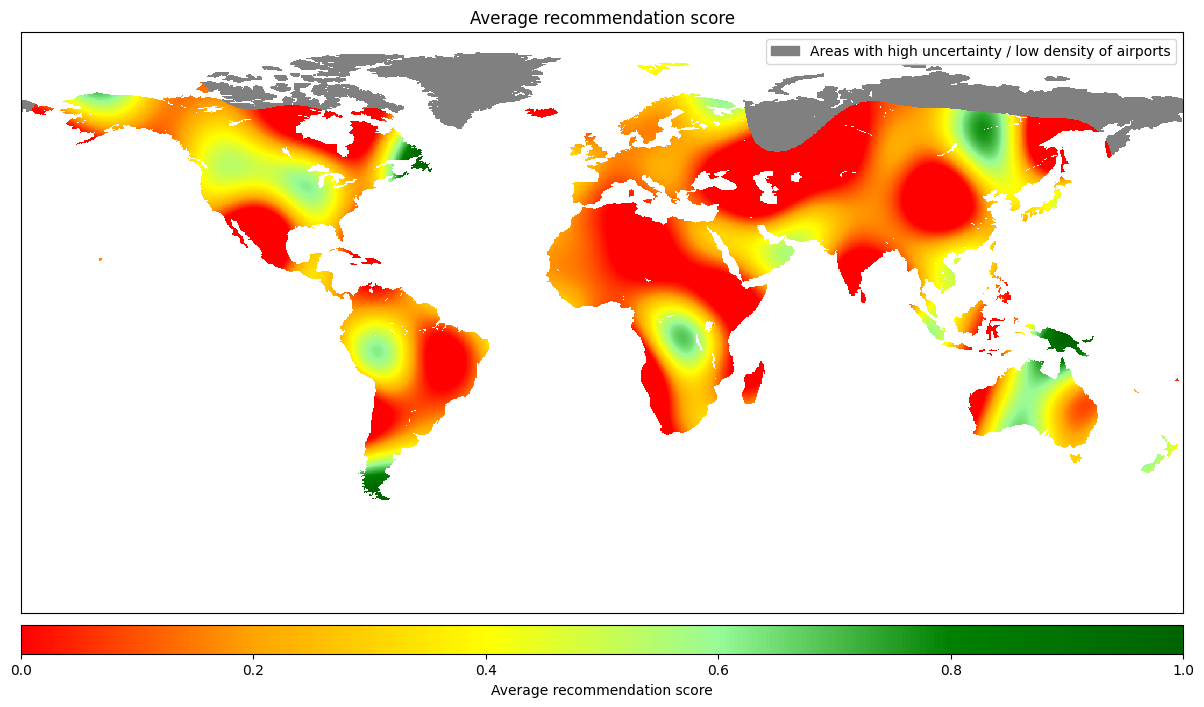

In [58]:
airports = pd.read_csv("data/airports_cleaned.csv")
airports_all_reviews = airports.dropna(subset=["average_recommendation"])
X_coordinates = airports_all_reviews[["latitude", "longitude"]].to_numpy()
number_of_reviews = airports_all_reviews["number_of_reviews"].to_numpy()
avg_rec = airports_all_reviews["average_recommendation"].to_numpy()
alfa, beta = number_of_reviews * avg_rec + 1, number_of_reviews * (1 - avg_rec) + 1
beta_dist_var = alfa * beta / ((alfa + beta) ** 2 * (alfa + beta + 1))

lons, lats, ymesh, uncertainty = fit_gp(X_coordinates, avg_rec, beta_dist_var, length_scale=15, resolution=1000)
max_rec_uncertainty = np.percentile(uncertainty, 50)
ymesh = np.clip(ymesh, 0, 1) ## make sure the values are between 0 and 1. the GP can predict values outside this range
visualize_gp(
    lons, 
    lats, 
    ymesh, 
    uncertainty, 
    max_rec_uncertainty, 
    title="Average recommendation score", 
    label="Average recommendation score"
    )

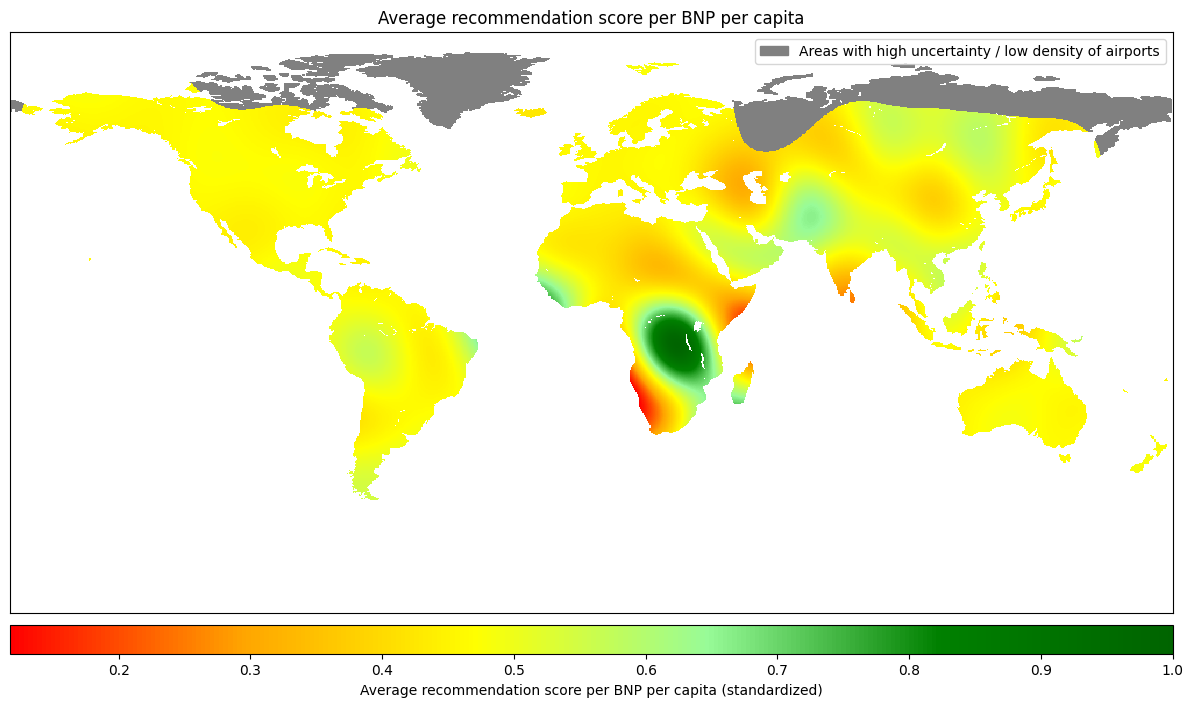

In [59]:
avg_rec_per_bnp = airports_all_reviews["recommended_BNP_ratio"].to_numpy()

lons, lats, ymesh, _ = fit_gp(X_coordinates, avg_rec_per_bnp, beta_dist_var, length_scale=15, resolution=1000)
## standardize ymesh between 0 and 1. dont clip it
min_ymesh, max_ymesh = np.min(ymesh), np.max(ymesh)
ymesh = (ymesh - min_ymesh) / (max_ymesh - min_ymesh)

visualize_gp(
    lons, 
    lats, 
    ymesh, 
    uncertainty,            ## use same uncertainty and max uncertainty as before 
    max_rec_uncertainty,    ## -||-
    title="Average recommendation score per BNP per capita", 
    label="Average recommendation score per BNP per capita (standardized)"
    )

# Where are the very good airports?

We can inspect the above plot can conclude the following:
* Most airports are very poorly rated all over the world. 
* Highly rated airports are not neccesarily placed in developing countries, but seems scattered all over the globe
* A few airports in Africa seems to severely outperform all other airports in terms of rating per BNP per capita.
* Most countries are "yellow" when adjusted for BNP, i.e. they perform equally well when adjusted for BNP.

Below, we'll look at the top 5 best rated airports, and top 5 best rated when adjusted for BNP. We'll also show pictures from these airports. We will only inspect airports with more than 10 reviews.

In [63]:
topk = 5
min_num_reviews = 5

## we only look at airports with more than x reviews
airport_best_avg_rec = airports_all_reviews[airports_all_reviews["number_of_reviews"] > min_num_reviews].sort_values("average_recommendation", ascending=False).iloc[:topk]
print(f"Top {topk} airports with the best average recommendation score:")
## pretty print the dataframe
print(airport_best_avg_rec[["id", "average_recommendation", "recommended_BNP_ratio", "number_of_reviews"]])

print("\n" * 2)
airport_best_avg_rec_per_bnp = airport_best_avg_rec = airports_all_reviews[airports_all_reviews["number_of_reviews"] > min_num_reviews].sort_values("recommended_BNP_ratio", ascending=False).iloc[:topk]
print(f"Top {topk} airports with the best average recommendation score per BNP per capita:")
print(airport_best_avg_rec_per_bnp[["id", "average_recommendation", "recommended_BNP_ratio", "number_of_reviews"]])

Top 5 airports with the best average recommendation score:
                    id  average_recommendation  recommended_BNP_ratio  \
1257   Samedan Airport                0.750000               0.981093   
3955       Lar Airport                0.714286               4.545491   
480      Kerry Airport                0.666667               0.831442   
412   Southend Airport                0.655172               1.299618   
403   Guernsey Airport                0.571429               1.576234   

      number_of_reviews  
1257                8.0  
3955                7.0  
480                 6.0  
412                29.0  
403                 7.0  



Top 5 airports with the best average recommendation score per BNP per capita:
                     id  average_recommendation  recommended_BNP_ratio  \
3761  Shinyanga Airport                0.571429              22.087984   
852        Fria Airport                0.250000              10.856781   
3966  Hyderabad Airport                0.33

# Network analysis
We want to make a smaller graph which consists of a subset of nodes, that is those nodes which have a rating. We make this small graph only with reviews to better analyse the airports with ratings. 

In [62]:
with open('data/graphnetwork.gpickle', 'rb') as f:
    G : nx.Graph = pickle.load(f)

airports_with_reviews_IATA = airports_with_reviews["IATA"].to_list()
## make a subgraph of the airports with reviews
G_reviews = G.subgraph(airports_with_reviews_IATA)
G_reviews = nx.Graph(G_reviews)
print("Number of nodes in subgraph:", G_reviews.number_of_nodes())

## save the subgraph to a file
with open('data/graphnetwork_reviews.gpickle', 'wb') as f:
    pickle.dump(G_reviews, f, pickle.HIGHEST_PROTOCOL)
    print("Saved subgraph to file")

Number of nodes in subgraph: 243
Saved subgraph to file
